In [1]:
# Import all packages
import torch
import torchvision
import numpy as np
from PIL import Image
from torchvision import transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from torch.nn import functional as F
import torch.nn as nn

from tqdm import tqdm
import copy
import timeit

In [2]:
# Load the label of COCO dataset
coco = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
        'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
        'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 
                          'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 
        'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 
                  'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 
        'N/A', 'dining table', 
        'N/A', 'N/A', 'toilet', 
        'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 
        'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [3]:
# Load pretrained Faster-RCNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) 
model.eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [4]:
# Print all layers of Faster-RCNN
for n, p in model.named_modules():
  print(n)


transform
backbone
backbone.body
backbone.body.conv1
backbone.body.bn1
backbone.body.relu
backbone.body.maxpool
backbone.body.layer1
backbone.body.layer1.0
backbone.body.layer1.0.conv1
backbone.body.layer1.0.bn1
backbone.body.layer1.0.conv2
backbone.body.layer1.0.bn2
backbone.body.layer1.0.conv3
backbone.body.layer1.0.bn3
backbone.body.layer1.0.relu
backbone.body.layer1.0.downsample
backbone.body.layer1.0.downsample.0
backbone.body.layer1.0.downsample.1
backbone.body.layer1.1
backbone.body.layer1.1.conv1
backbone.body.layer1.1.bn1
backbone.body.layer1.1.conv2
backbone.body.layer1.1.bn2
backbone.body.layer1.1.conv3
backbone.body.layer1.1.bn3
backbone.body.layer1.1.relu
backbone.body.layer1.2
backbone.body.layer1.2.conv1
backbone.body.layer1.2.bn1
backbone.body.layer1.2.conv2
backbone.body.layer1.2.bn2
backbone.body.layer1.2.conv3
backbone.body.layer1.2.bn3
backbone.body.layer1.2.relu
backbone.body.layer2
backbone.body.layer2.0
backbone.body.layer2.0.conv1
backbone.body.layer2.0.bn1
bac

In [5]:
def get_prediction(pred, threshold):
  """
  get_prediction
    Parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    ethod:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
    
  """
  pred_class = pred[0]['labels'].cpu().numpy()
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].cpu().detach().numpy())]
  pred_score = list(pred[0]['scores'].cpu().detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold]
  if len(pred_t) == 0:
    flag = 0.
    return flag
  else:
    pred_t = pred_t[-1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  scores = pred_score[:pred_t+1]
  return (pred_boxes, pred_class, scores)

In [6]:
import matplotlib.colors as mcolors
overlap = {name for name in mcolors.CSS4_COLORS
           if f'xkcd:{name}' in mcolors.XKCD_COLORS}
all_colors = []
for color_name in overlap:
  css4 = mcolors.CSS4_COLORS[color_name]
  all_colors.append(css4)
  xkcd = mcolors.XKCD_COLORS[f'xkcd:{color_name}'].upper()
  all_colors.append(xkcd)

In [7]:
!wget https://raw.githubusercontent.com/Tianxiaomo/pytorch-YOLOv4/master/data/dog.jpg

--2022-11-15 06:36:10--  https://raw.githubusercontent.com/Tianxiaomo/pytorch-YOLOv4/master/data/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163759 (160K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 159.92K  --.-KB/s    in 0.02s   

2022-11-15 06:36:10 (10.0 MB/s) - ‘dog.jpg’ saved [163759/163759]



In [8]:
!wget https://raw.githubusercontent.com/hysts/pytorch_D-RISE/main/images/image02.jpg

--2022-11-15 06:36:10--  https://raw.githubusercontent.com/hysts/pytorch_D-RISE/main/images/image02.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242382 (237K) [image/jpeg]
Saving to: ‘image02.jpg’

image02.jpg         100%[===================>] 236.70K  --.-KB/s    in 0.02s   

2022-11-15 06:36:11 (12.9 MB/s) - ‘image02.jpg’ saved [242382/242382]



In [9]:
!wget https://raw.githubusercontent.com/Tianxiaomo/pytorch-YOLOv4/master/data/giraffe.jpg

--2022-11-15 06:36:11--  https://raw.githubusercontent.com/Tianxiaomo/pytorch-YOLOv4/master/data/giraffe.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 382965 (374K) [image/jpeg]
Saving to: ‘giraffe.jpg’

giraffe.jpg         100%[===================>] 373.99K  --.-KB/s    in 0.02s   

2022-11-15 06:36:11 (15.3 MB/s) - ‘giraffe.jpg’ saved [382965/382965]



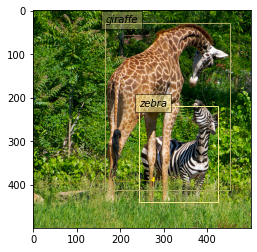

In [10]:
device = torch.device('cuda')
# Load image
path = './giraffe.jpg'
transform = T.Compose([T.ToTensor()])
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
org_h, org_w, _ = img.shape

# Get prediction
model.to(device)
inp = transform(img)
prediction = model([inp.to(device)])
rs = get_prediction(prediction, 0.5)

# Show prediction
boxes, pred_cls, pred = rs
fig, ax = plt.subplots()
ax.imshow(img)
for i in range(len(boxes)): 
  x_min, y_min = boxes[i][0]
  x_max, y_max = boxes[i][1]
  rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor=all_colors[pred_cls[i]], facecolor='none')
  ax.add_patch(rect)
  ax.text(x_min, y_min, coco[pred_cls[i]], style='italic', bbox={
        'facecolor': all_colors[pred_cls[i]], 'alpha': 0.5,})

for i in range(len(boxes)):
  boxes[i].append(pred_cls[i])
  boxes[i].append(pred[i])

In [11]:
from math import floor
import math
# This function to create Gaussian mask used in algorithm
def create_heatmap(output_width, output_height, p_x, p_y, sigma):
    """
    Parameters: 
      - output_width, output_height: The kernel size of Gaussian mask
      - p_x, p_y: The center of Gaussian mask
      - sigma: The standard deviation of Gaussian mask
    Returns:
      - mask: The 2D-array Gaussian mask in range [0, 1]
    """
    X1 = np.linspace(1, output_width, output_width)
    Y1 = np.linspace(1, output_height, output_height)
    [X, Y] = np.meshgrid(X1, Y1)
    X = X - floor(p_x)
    Y = Y - floor(p_y)
    D2 = X * X + Y * Y
    E2 = 2.0 * sigma ** 2
    Exponent = D2 / E2
    mask = np.exp(-Exponent)
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    return mask

class GCAME(object):
    def __init__(self, model, target_layer, img_size=(640, 640), **kwargs):
        """
        Parameters:
          - model: The model in nn.Module() to analyze
          - target_layers: List of names of the target layers in model.named_modules()
          - img_size: The size of image in tuple
        Variables:
          - self.gradients, self.activations: Dictionary to save the value when
            do forward/backward in format {'name_layer': activation_map/gradient}
          - self.handlers: List of hook functions
        """
        self.model = model.eval()
        self.img_size = img_size
        self.gradients = dict()
        self.activations = dict()
        self.target_layer = target_layer
        self.handlers = []

        def save_grads(key):    
            def backward_hook(module, grad_inp, grad_out):
                self.gradients[key] = grad_out[0].detach()
            return backward_hook

        def save_fmaps(key):
            def forward_hook(module, inp, output):
                self.activations[key] = output
            return forward_hook
        
        for name, module in list(self.model.named_modules())[1:]:
            
            if name in self.target_layer:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def remove_hook(self):
      """
      Remove all the forward/backward hook functions
      """
      for handle in self.handlers:
          handle.remove()

    def __call__(self, img, box, index=None):
      return self.forward(img, box, index)

    def forward(self, img, box, index=None):
      """
      Parameters:
        - img: input image in Tensor[3, H, W]
        - box: The bounding box to analyze List[(xmin, ymin), (xmax, ymax), cls, score]
        - index: The index of target bounding box in int
      Returns:
        - score_saliency_map: The saliency map of target object
      """
  
      c, h, w = img.size()
      org_size = (h, w)

      # Get input image size
      transform_img = self.model.transform([img])[0]
      self.img_size = transform_img.image_sizes[0]
      self.model.zero_grad()

      # Get prediction
      output = self.model([img])
      output[0]['scores'][index].backward(retain_graph=True)

      # Create saliency map
      score_saliency_map = np.zeros((org_size))

      for target_layer in self.target_layer:
        map = self.activations[target_layer]
        grad = self.gradients[target_layer]

        # Select the branch that the target comes out
        if grad.max() == 0 and grad.min() == 0:
          continue

        map = map.squeeze().detach().cpu().numpy()
        grad = grad.squeeze().detach().cpu().numpy()

        # Calculate the proportion between the input image and the gradient map
        stride = math.sqrt((self.img_size[0] * self.img_size[1]) / (grad.shape[1] * grad.shape[2]))

        for j in tqdm(range(map.shape[0])):
          new_map = copy.deepcopy(map[j])
          pos_grad = copy.deepcopy(grad[j])
          neg_grad = copy.deepcopy(grad[j])

          # Get the positive part of gradient map
          pos_grad[pos_grad < 0] = 0
          mean_pos_grad = np.mean(pos_grad)
          max_grad = pos_grad.max()
          idx, idy = (pos_grad == max_grad).nonzero()
          if len(idx) == 0 or len(idy) == 0 or mean_pos_grad == 0:
            continue

          idx = idx[0]
          idy = idy[0]
          kn_size = math.floor((math.sqrt(grad.shape[1] * grad.shape[2]) - 1) / 2) / 3
          pos_sigma = (np.log(abs(mean_pos_grad)) / kn_size) * np.log(stride)

          pos_sigma = max(abs(pos_sigma), 1.)
          pos_mask = create_heatmap(grad[j].shape[1], grad[j].shape[0], idy, idx, pos_sigma)
          pos_weighted_map = (new_map * mean_pos_grad) * pos_mask

          # Get the negative part of gradient map
          neg_grad[neg_grad > 0] = 0
          mean_neg_grad = np.mean(neg_grad)
          if mean_neg_grad == 0:
            continue

          min_grad = np.unique(neg_grad[neg_grad != 0])[-1]
          idx_, idy_ = (neg_grad == min_grad).nonzero()
          if len(idx_) == 0 or len(idy_) == 0:
            continue

          idx_ = idx_[0]
          idy_ = idy_[0]
          neg_sigma = (np.log(abs(mean_neg_grad)) / kn_size) * np.log(stride)
          neg_sigma = max(abs(neg_sigma), 1.)
          neg_mask = create_heatmap(grad[j].shape[1], grad[j].shape[0], idy_, idx_, neg_sigma)
          neg_weighted_map = (new_map * mean_neg_grad) * neg_mask
          
          # Sum up the weighted feature map
          weighted_map = pos_weighted_map - neg_weighted_map
          weighted_map = cv2.resize(weighted_map, (org_size[1], org_size[0]))
          weighted_map[weighted_map < 0.] = 0.
          score_saliency_map += weighted_map

      score_saliency_map = (score_saliency_map - score_saliency_map.min()) / (score_saliency_map.max() - score_saliency_map.min())
      return score_saliency_map

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 256/256 [00:00<00:00, 596.44it/s]

Time: 1.921330128999898s


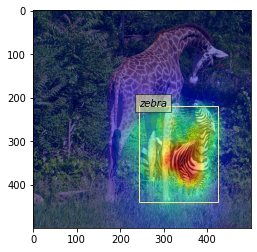

In [12]:
target_layer = [
    # 'backbone.fpn.inner_blocks.0.0',
    'backbone.fpn.layer_blocks.0.0',

    # 'backbone.fpn.inner_blocks.1.0',
    'backbone.fpn.layer_blocks.1.0',

    'backbone.fpn.inner_blocks.2.0',
    'backbone.fpn.layer_blocks.2.0',

    # 'backbone.fpn.inner_blocks.3.0',
    'backbone.fpn.layer_blocks.3.0',
]

idx = 0
cam = GCAME(model, target_layer)
inp = inp.to(device)
start = timeit.default_timer()
out = cam(inp, [boxes[idx]],index=idx)
stop = timeit.default_timer()

print("Time: {}s".format(stop-start))
box = boxes[idx]
(x_min, y_min), (x_max, y_max), cls, score = box
fig, ax = plt.subplots()
ax.imshow(img)
rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor=all_colors[cls], facecolor='none')
ax.add_patch(rect)
ax.text(x_min, y_min, coco[cls], style='italic', bbox={
    'facecolor': all_colors[cls], 'alpha': 0.5,})
ax.imshow(out, cmap='jet', alpha=0.5)

In [14]:
def bbox_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou


class DRISE(object):
    def __init__(self, model, img_size=(608, 608), grid_size=(16, 16), n_samples=1000, prob_thresh=0.2, seed=0, device='cpu', **kwargs):
        """
        Parameters:
          - model: The model in nn.Modules() to analyze
          - img_size: The image size in tuple (H, W)
          - grid_size: The grid size in tuple (h, w)
          - n_samples: Number of samples to create
          - prob_thresh: The appearence probability of 1 grid 
        """
        self.model = model.eval()
        self.img_size = img_size
    
        self.grid_size = grid_size
        self.n_samples = n_samples
        self.prob_thresh = prob_thresh
        self.seed = seed
        self.device = device
    
    def __call__(self, image, box):
        return self.generate_saliency_map(image, box)

    def generate_mask(self,):
        """
        Return a mask with shape [H, W]
        """
        image_h, image_w = self.img_size
        grid_h, grid_w = self.grid_size

        # Create cell for mask
        cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
        up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h
        
        # Create {0, 1} mask
        mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
                self.prob_thresh).astype(np.float32)
        # Up-size to get value in [0, 1]
        mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
        # Randomly crop the mask
        offset_w = np.random.randint(0, cell_w)
        offset_h = np.random.randint(0, cell_h)
        
        mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
        return mask
    
    
    def mask_image(self, image, mask):
        """
        Return a masked image with [0, 1] mask
        """
        masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) *
                    255).astype(np.uint8)
        return masked

    def generate_saliency_map(self, img, box):
        transform = T.Compose([T.ToTensor()])
        np.random.seed(self.seed)
        h, w, c = img.shape
        self.img_size = (h, w)
        saliency_map = np.zeros((h, w), dtype=np.float32)
        target_class = box[2]
        target_score = box[3]
        target_box = list(box[0]) + list(box[1])
        count = 0
        for _ in tqdm(range(self.n_samples)):
          # Create n_samples
          count += 1
          mask = self.generate_mask()
          masked = self.mask_image(img, mask)
          masked = transform(masked)
          masked = masked.unsqueeze(0)
          
          ious = []
          all_scores_map = []
          self.model.zero_grad()
          with torch.no_grad():
            prediction = self.model(masked.to(device))
          pred_class = list(prediction[0]['labels'].cpu().numpy())
          pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(prediction[0]['boxes'].cpu().detach().numpy())]
          pred_score = list(prediction[0]['scores'].cpu().detach().numpy())
          pred_t = [pred_score.index(x) for x in pred_score if x>0.5]
          if len(pred_t) == 0:
            continue
            
          pred_t = pred_t[-1]
          pred_boxes = pred_boxes[:pred_t+1]
          pred_class = pred_class[:pred_t+1]
          scores = pred_score[:pred_t+1]
          for b in range(len(pred_boxes)):
            if pred_class[b] != target_class:
              continue
            else:
              new_bbox = list(pred_boxes[b][0]) + list(pred_boxes[b][1])
            
              # cosine = (target_score * scores[b]) / math.sqrt(pow(target_score, 2) + pow(scores[b], 2))
              iou = bbox_iou(new_bbox, target_box)
              ious.append(iou)
              all_scores_map.append(scores[b])
          
          if len(ious) == 0:
            continue
          t = mask * np.max(ious) * all_scores_map[np.argmax(ious)]
          saliency_map += t
          M, m = saliency_map.max(), saliency_map.min()
          saliency_map = (saliency_map - m) / (M - m)

        return saliency_map

In [15]:
h, w, c = img.shape
cam = DRISE(model, img_size=(h, w), n_samples=4000, device=device)
out = cam(img, boxes[0])

100%|██████████| 4000/4000 [05:52<00:00, 11.34it/s]


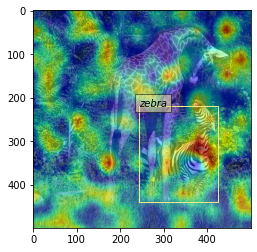

In [16]:
idx = 0
box = boxes[idx]
(x_min, y_min), (x_max, y_max), cls, score = box
fig, ax = plt.subplots()
ax.imshow(img)
rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor=all_colors[cls], facecolor='none')
ax.add_patch(rect)
ax.text(x_min, y_min, coco[cls], style='italic', bbox={
    'facecolor': all_colors[cls], 'alpha': 0.5,})
ax.imshow(out, cmap='jet', alpha=0.5)